In [1]:
# TensorFlow and tf.keras

# import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow.keras.utils
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Import data

In [2]:
data = np.load('/mnt/data/ml/ShowJetsData1.npz')
# !ls /mnt/data/ml/
images = data['jetImages']
labels = data['labels']
grid = np.size(images, 1)
#ensure same number of signal vs. background and even split of z events
qcd_im = images[np.where(labels[:,0] == 1)]
if len(qcd_im) % 3 != 0:
    qcd_im = qcd_im[:len(qcd_im)-(len(qcd_im) % 3)]
z1_im = images[np.where(labels[:,1] == 1)]
z1_im = z1_im[:int(len(qcd_im)/3)]
z2_im = images[np.where(labels[:,2] == 1)]
z2_im = z2_im[:int(len(qcd_im)/3)]
z3_im = images[np.where(labels[:,3] == 1)]
z3_im = z3_im[:int(len(qcd_im)/3)]
print(len(z1_im), len(z2_im), len(z3_im), len(qcd_im))
qcd_lab = np.zeros([len(qcd_im), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_im), 2])
z_lab[:,1] = 1
images = np.vstack((qcd_im, z1_im, z2_im, z3_im))
labels = np.vstack((qcd_lab, z_lab))
n_data = len(images)
images = images.reshape(n_data, grid, grid, 1)
#split data into testing/training/validation

testimages = images[::4]
testlabels = labels[::4]
mask_im = np.ones(images.shape,dtype=bool)
mask_im[::4] = 0
mask_im[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
valimages = images[1::8]
vallabels = labels[1::8]

trainimages = images[mask_im].reshape((n_data-len(testimages)-len(valimages)), grid, grid, 1)
trainlabels = labels[mask_lab].reshape((n_data-len(testimages)-len(valimages)), 2)

16540 16540 16540 49620


Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

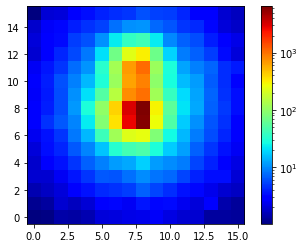

In [3]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if trainlabels[i,0] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'Greens', norm=LogNorm())
plt.colorbar()
plt.show()

Build DNN:

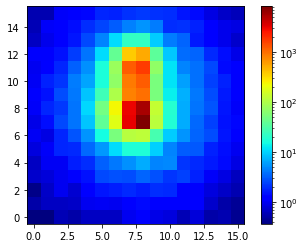

In [4]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'Greens', norm=LogNorm())
plt.colorbar()
plt.show()

In [5]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1), name = 'input')
    x = layers.Conv2D(64, (12, 12), padding = 'same', activation='relu', name = 'conv1')(input1)
    x = layers.Conv2D(64, (6, 6), padding = 'same', activation='relu', name = 'conv2')(x)
    x = layers.Conv2D(64, (4, 4), padding = 'same', activation='relu', name = 'conv3')(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool1')(x)
#     x = layers.Conv2D(32, (4, 4), padding = 'same', activation='relu', name = 'conv4')(x)
#     x = layers.Conv2D(32, (3, 3), padding = 'same', activation='relu', name = 'conv5')(x)
#     x = layers.Conv2D(32, (2, 2), padding = 'same', activation='relu', name = 'conv6')(x)
#     x = layers.MaxPool2D((2, 2), name = 'maxpool2')(x)
    x = layers.Flatten(name = 'flatten')(x)
#     x = layers.Dense(64, activation='relu', name = 'relu1')(x)
#     x = layers.Dense(256, activation='relu', name = 'relu2')(x)
    x = layers.Dense(256, activation='relu', name = 'relu3')(x)
    output = layers.Dense(2, activation='softmax', name = 'softmax')(x)
    model = models.Model(inputs=input1, outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

Initialize model:

In [6]:
CNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


Test model's prediction $before$ training:

In [7]:
example_batch = trainimages[::300]
example_labels = trainlabels[::300]
# example_radii = trainradii[:10]
# example_theta = traintheta[:10]
# example_z = trainz[:10]
example_result = CNN.predict(x = example_batch)
results = CNN.evaluate(x = example_batch, y = example_labels, verbose = 0)
print(example_result)
print(results)

[[0.5032421  0.49675792]
 [0.5025284  0.49747148]
 [0.50241715 0.49758288]
 [0.50294423 0.4970557 ]
 [0.5035009  0.49649912]
 [0.5020624  0.4979376 ]
 [0.5024052  0.4975947 ]
 [0.5030817  0.4969183 ]
 [0.5027102  0.4972898 ]
 [0.5021157  0.49788433]
 [0.5025892  0.4974108 ]
 [0.5011588  0.4988412 ]
 [0.5019574  0.49804258]
 [0.5014893  0.4985107 ]
 [0.5027429  0.49725708]
 [0.502256   0.49774402]
 [0.502762   0.49723807]
 [0.50181    0.49819   ]
 [0.5017056  0.49829438]
 [0.5019313  0.4980687 ]
 [0.50217855 0.49782145]
 [0.50295097 0.497049  ]
 [0.5015843  0.49841574]
 [0.50151473 0.49848533]
 [0.50214654 0.49785343]
 [0.50256896 0.49743098]
 [0.50261855 0.4973814 ]
 [0.50203454 0.49796548]
 [0.50330657 0.49669343]
 [0.5033206  0.4966795 ]
 [0.50200725 0.49799272]
 [0.5022664  0.4977336 ]
 [0.5023655  0.4976344 ]
 [0.5030755  0.49692452]
 [0.5029725  0.49702755]
 [0.5031933  0.49680668]
 [0.50413936 0.49586067]
 [0.5021482  0.49785176]
 [0.5026248  0.4973752 ]
 [0.5022578  0.49774215]


In [ ]:
checkpoint_path = "model/CNN_images1.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(
  trainimages, trainlabels,
  epochs=EPOCHS, validation_data = (valimages, vallabels), verbose = 1,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 62025 samples, validate on 12405 samples
Epoch 1/50
62025/62025 [==============================] - 655s 11ms/step - loss: 0.5677 - categorical_crossentropy: 0.5677 - acc: 0.7135 - val_loss: 0.5498 - val_categorical_crossentropy: 0.5498 - val_acc: 0.7281

Epoch 00001: val_loss improved from inf to 0.54977, saving model to model/CNN_images1.h5
Epoch 2/50
62025/62025 [==============================] - 570s 9ms/step - loss: 0.5387 - categorical_crossentropy: 0.5387 - acc: 0.7407 - val_loss: 0.5395 - val_categorical_crossentropy: 0.5395 - val_acc: 0.7389

Epoch 00002: val_loss improved from 0.54977 to 0.53946, saving model to model/CNN_images1.h5
Epoch 3/50
34400/62025 [===============>..............] - ETA: 3:55 - loss: 0.5339 - categorical_crossentropy: 0.5339 - acc: 0.7430

Now make a plot that shows the pregression of accuracy through each training epoch.

In [ ]:
# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch
  
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error')
#   plt.plot(hist['epoch'], hist['binary'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#   plt.ylim([0,100])
#   plt.legend()
#   plt.show()

# plot_history(history)

Load best weights.

In [ ]:
!ls model
best_model = keras.models.load_model('model/CNN_images1.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels, verbose = 0)
print(results)

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [ ]:
predict = best_model.predict(testimages)

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
indqcd = np.argwhere(testlabels[:,1] == 0)
ind1  = np.where(testlabels[:,1] == 1) 
# ind2  = np.where(testlabels[:,2] == 1)
# ind3  = np.where(testlabels[:,3] == 1)
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[ind1, 1].flatten()] , histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/o normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()